In [1]:
import numpy as np
import torch
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
import time
import ot
import ot.plot
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn import manifold
import matplotlib.pyplot as pl
import umap
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import ot.plot
import pandas as pd

In [2]:
import sys
sys.path.append('../code/')
from HierarchicalOT import load_wmd_data,change_embeddings,reduce_vocab,fit_topics,sparseOT
from sinkhorn_iterates import sinkhorn
from linear_solver import UOT_W
from utils import plot2D_plan,plot2D_plan_vocab

# t-SNE and U-map representation of Wasserstein distance matrices

In [71]:
data_path = './data/WordMoverDistances/'
embeddings_path = './data/WordMoverDistances/glove.6B/glove.6B.300d.txt'

# Pick a dataset (n_doc,n_vocab)
#data_name = 'bbcsport-emd_tr_te_split.mat' #(737,3657)
#data_name = 'twitter-emd_tr_te_split.mat' #(3108, 1205)
#data_name = 'r8-emd_tr_te3.mat' # (7674,5495)
#data_name = 'amazon-emd_tr_te_split.mat' #(8000, 16753)
data_name = 'classic-emd_tr_te_split.mat' # (7093, 5813)

vocab, embed_vocab, bow_data, y = load_wmd_data(data_path + data_name)
y = y - 1
vocab, embed_vocab, bow_data = change_embeddings(vocab, bow_data, embeddings_path) # embed in Glove

vocab, embed_vocab, bow_data = reduce_vocab(bow_data, vocab, embed_vocab, embed_aggregate='mean') # Reduce vocabulary by removing short words, stop words, and stemming (root words?)
embeddings = np.array([embed_vocab[w] for w in vocab])
cost_embeddings = euclidean_distances(embeddings, embeddings) ** 2 # Matrix of word embeddings: nb_vocab x 300

In [72]:
bow_data.shape,y.min(),y.max()

((7093, 5813), 0, 3)

In [73]:
label_color=[]
y_label=["1","2","3","4","5","6","7","8","9","10"]
for i in range(y.shape[0]):
    label_color+=["C%i"%y[i]]

if data_name == 'bbcsport-emd_tr_te_split.mat':
    y_label[0:5]=["Athletism","Cricket","Football","Rubgy","Tenis"] # Label for BBC
elif data_name =='twitter-emd_tr_te_split.mat':
    y_label[0:3]=["Positive","Negative","Neutral"]# Label for Twitter
elif data_name=='r8-emd_tr_te3.mat':
    y_label[0:8]=["1","2","3","4","5","6","7","8"]#
elif data_name=='amazon-emd_tr_te_split.mat':
    y_label[0:4]=["Books","Dvd","Electronics","Kitchen"]# Label for Amazon
elif data_name=='classic-emd_tr_te_split.mat':
    y_label[0:4]=["1","2","3","4"]#
elif data_name=='ohsumed-emd_tr_te_ix.mat':
    y_label=["1","2","3","4","5","6","7","8","9","10"]# 

### WMD

In [74]:
WMD=np.loadtxt("result/WordMoverDistances/WMD_"+data_name+".txt")    

In [75]:
#WMD_low = manifold.TSNE(n_components=2,random_state=0,metric="precomputed",early_exaggeration=50.0).fit_transform(WMD)
WMD_low = umap.UMAP(random_state=0,metric="precomputed").fit_transform(WMD)

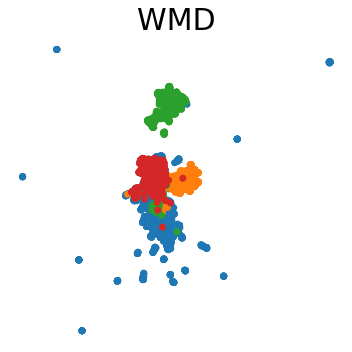

In [76]:
pl.figure(figsize=(5,5))
pl.scatter(WMD_low[:,0],WMD_low[:,1],c=label_color)
label1 = Line2D([0], [0], label=y_label[0], marker='o', color='C0', linestyle='')
label2 = Line2D([0], [0], label=y_label[1], marker='o', color='C1', linestyle='')
label3 = Line2D([0], [0], label=y_label[2], marker='o', color='C2', linestyle='')
label4 = Line2D([0], [0], label=y_label[3], marker='o', color='C3', linestyle='')
label5 = Line2D([0], [0], label=y_label[4], marker='o', color='C4', linestyle='')
label6 = Line2D([0], [0], label=y_label[4], marker='o', color='C5', linestyle='')
label7 = Line2D([0], [0], label=y_label[4], marker='o', color='C6', linestyle='')
label8 = Line2D([0], [0], label=y_label[4], marker='o', color='C7', linestyle='')
label9 = Line2D([0], [0], label=y_label[4], marker='o', color='C8', linestyle='')
label10 = Line2D([0], [0], label=y_label[4], marker='o', color='C9', linestyle='')
handles, labels = pl.gca().get_legend_handles_labels()
if data_name == 'bbcsport-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4,label5])
elif data_name =='twitter-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3])
elif data_name=='r8-emd_tr_te3.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8])
elif data_name=='amazon-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='classic-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='ohsumed-emd_tr_te_ix.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8,label9,label10])
pl.title("WMD",size=30)
pl.axis('off')
pl.tight_layout()
#pl.legend(handles=handles)
pl.savefig("../Figures/WMD/WMD_"+data_name+".pdf",bbox_inches='tight')

### HOTT

In [77]:
HOTT=np.loadtxt("result/WordMoverDistances/HOTT_"+data_name+".txt")
HOTT=abs(HOTT)

In [78]:
#HOTT_low = manifold.TSNE(n_components=2,metric="precomputed",early_exaggeration=50.0,random_state=0).fit_transform(HOTT)
HOTT_low = umap.UMAP(random_state=0,metric="precomputed").fit_transform(HOTT)

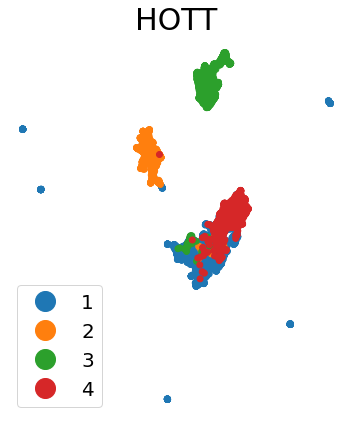

In [79]:
pl.figure(figsize=(5,6))
pl.scatter(HOTT_low[:,0],HOTT_low[:,1],c=label_color)
label1 = Line2D([0], [0], label=y_label[0], marker='o', color='C0', linestyle='',markersize=20)
label2 = Line2D([0], [0], label=y_label[1], marker='o', color='C1', linestyle='',markersize=20)
label3 = Line2D([0], [0], label=y_label[2], marker='o', color='C2', linestyle='',markersize=20)
label4 = Line2D([0], [0], label=y_label[3], marker='o', color='C3', linestyle='',markersize=20)
label5 = Line2D([0], [0], label=y_label[4], marker='o', color='C4', linestyle='',markersize=20)
label6 = Line2D([0], [0], label=y_label[4], marker='o', color='C5', linestyle='',markersize=20)
label7 = Line2D([0], [0], label=y_label[4], marker='o', color='C6', linestyle='',markersize=20)
label8 = Line2D([0], [0], label=y_label[4], marker='o', color='C7', linestyle='',markersize=20)
label9 = Line2D([0], [0], label=y_label[4], marker='o', color='C8', linestyle='',markersize=20)
label10 = Line2D([0], [0], label=y_label[4], marker='o', color='C9', linestyle='',markersize=20)
handles, labels = pl.gca().get_legend_handles_labels()
if data_name == 'bbcsport-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4,label5])
elif data_name =='twitter-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3])
elif data_name=='r8-emd_tr_te3.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8])
elif data_name=='amazon-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='classic-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='ohsumed-emd_tr_te_ix.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8,label9,label10])
pl.title("HOTT",size=30)
pl.axis('off')
pl.tight_layout()
pl.legend(handles=handles,prop={'size': 20})
pl.savefig("../Figures/WMD/HOTT_"+data_name+".pdf",bbox_inches='tight')

# Latent OT

In [80]:
LOT=np.loadtxt("result/WordMoverDistances/LOT_"+data_name+".txt")
LOT=abs(LOT)

In [81]:
#LOT_low = manifold.TSNE(n_components=2,metric="precomputed",early_exaggeration=50.0,random_state=0).fit_transform(HOTT)
LOT_low = umap.UMAP(random_state=0,metric="precomputed").fit_transform(LOT)

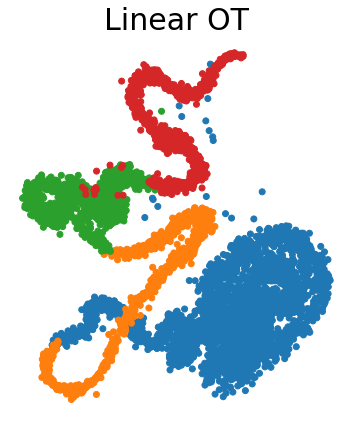

In [82]:
pl.figure(figsize=(5,6))
pl.scatter(LOT_low[:,0],LOT_low[:,1],c=label_color)
label1 = Line2D([0], [0], label=y_label[0], marker='o', color='C0', linestyle='')
label2 = Line2D([0], [0], label=y_label[1], marker='o', color='C1', linestyle='')
label3 = Line2D([0], [0], label=y_label[2], marker='o', color='C2', linestyle='')
label4 = Line2D([0], [0], label=y_label[3], marker='o', color='C3', linestyle='')
label5 = Line2D([0], [0], label=y_label[4], marker='o', color='C4', linestyle='')
label6 = Line2D([0], [0], label=y_label[4], marker='o', color='C5', linestyle='')
label7 = Line2D([0], [0], label=y_label[4], marker='o', color='C6', linestyle='')
label8 = Line2D([0], [0], label=y_label[4], marker='o', color='C7', linestyle='')
label9 = Line2D([0], [0], label=y_label[4], marker='o', color='C8', linestyle='')
label10 = Line2D([0], [0], label=y_label[4], marker='o', color='C9', linestyle='')
handles, labels = pl.gca().get_legend_handles_labels()
if data_name == 'bbcsport-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4,label5])
elif data_name =='twitter-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3])
elif data_name=='r8-emd_tr_te3.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8])
elif data_name=='amazon-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='classic-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='ohsumed-emd_tr_te_ix.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8,label9,label10])
pl.title("Linear OT",size=30)
pl.axis('off')
pl.tight_layout()
#pl.legend(handles=handles)
pl.savefig("../Figures/WMD/LOT_"+data_name+".pdf",bbox_inches='tight')

### RebOT entropic

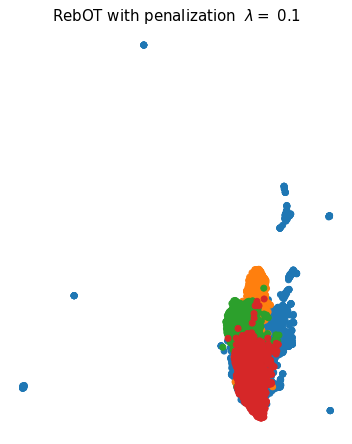

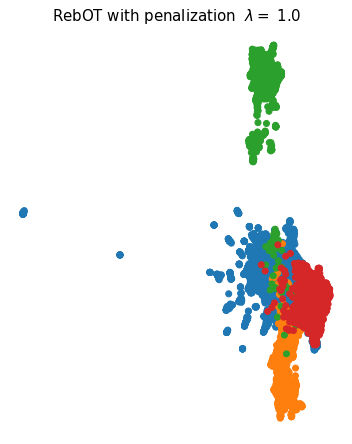

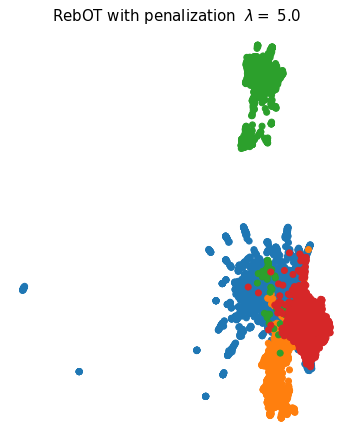

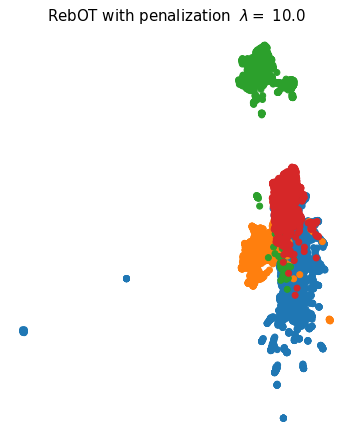

In [83]:
for l in [.1,1,5,10]:
    #UOT1=np.loadtxt("result/WordMoverDistances/UOTeP_"+data_name+"_"+str(l)+".txt") #Only with the plan
    UOT2=np.loadtxt("result/WordMoverDistances/UOTe_"+data_name+"_"+str(l)+".txt") #Plan and divergences
    #UOT1=abs(UOT1)
    UOT2=abs(UOT2)
    #UOT1[np.isnan(UOT1)] = 0
    UOT2[np.isnan(UOT2)] = 0
    
    #WMD1_low = manifold.TSNE(n_components=2,metric="precomputed",early_exaggeration=50.0,random_state=0).fit_transform(WMDuot1)
    #WMD2_low = manifold.TSNE(n_components=2,metric="precomputed",early_exaggeration=50.0,random_state=0).fit_transform(WMDuot2)

    #WMD1_low = umap.UMAP(random_state=0,metric="precomputed").fit_transform(UOT1)
    WMD2_low = umap.UMAP(random_state=0,metric="precomputed").fit_transform(UOT2)
    pl.figure(figsize=(5,6))
    """
    pl.subplot(1,2,1)
    pl.scatter(WMD1_low[:,0],WMD1_low[:,1],c=label_color)
    label1 = Line2D([0], [0], label=y_label[0], marker='o', color='C0', linestyle='')
    label2 = Line2D([0], [0], label=y_label[1], marker='o', color='C1', linestyle='')
    label3 = Line2D([0], [0], label=y_label[2], marker='o', color='C2', linestyle='')
    label4 = Line2D([0], [0], label=y_label[3], marker='o', color='C3', linestyle='')
    label5 = Line2D([0], [0], label=y_label[4], marker='o', color='C4', linestyle='')
    label6 = Line2D([0], [0], label=y_label[4], marker='o', color='C5', linestyle='')
    label7 = Line2D([0], [0], label=y_label[4], marker='o', color='C6', linestyle='')
    label8 = Line2D([0], [0], label=y_label[4], marker='o', color='C7', linestyle='')
    label9 = Line2D([0], [0], label=y_label[4], marker='o', color='C8', linestyle='')
    label10 = Line2D([0], [0], label=y_label[4], marker='o', color='C9', linestyle='')
    handles, labels = pl.gca().get_legend_handles_labels()
    if data_name == 'bbcsport-emd_tr_te_split.mat':
        handles.extend([label1,label2,label3,label4,label5])
    elif data_name =='twitter-emd_tr_te_split.mat':
        handles.extend([label1,label2,label3])
    elif data_name=='r8-emd_tr_te3.mat':
        handles.extend([label1,label2,label3,label4,label5,label6,label7,label8])
    elif data_name=='amazon-emd_tr_te_split.mat':
        handles.extend([label1,label2,label3,label4])
    elif data_name=='classic-emd_tr_te_split.mat':
        handles.extend([label1,label2,label3,label4])
    elif data_name=='ohsumed-emd_tr_te_ix.mat':
        handles.extend([label1,label2,label3,label4,label5,label6,label7,label8,label9,label10])
    pl.title("RebOT without penalization  $\lambda =$ %1.1f"%l,size=15)
    pl.axis('off')
    pl.tight_layout()
    pl.legend(handles=handles)"""
    pl.subplot(1,1,1)
    pl.scatter(WMD2_low[:,0],WMD2_low[:,1],c=label_color)
    label1 = Line2D([0], [0], label=y_label[0], marker='o', color='C0', linestyle='')
    label2 = Line2D([0], [0], label=y_label[1], marker='o', color='C1', linestyle='')
    label3 = Line2D([0], [0], label=y_label[2], marker='o', color='C2', linestyle='')
    label4 = Line2D([0], [0], label=y_label[3], marker='o', color='C3', linestyle='')
    label5 = Line2D([0], [0], label=y_label[4], marker='o', color='C4', linestyle='')
    label6 = Line2D([0], [0], label=y_label[4], marker='o', color='C5', linestyle='')
    label7 = Line2D([0], [0], label=y_label[4], marker='o', color='C6', linestyle='')
    label8 = Line2D([0], [0], label=y_label[4], marker='o', color='C7', linestyle='')
    label9 = Line2D([0], [0], label=y_label[4], marker='o', color='C8', linestyle='')
    label10 = Line2D([0], [0], label=y_label[4], marker='o', color='C9', linestyle='')
    handles, labels = pl.gca().get_legend_handles_labels()
    if data_name == 'bbcsport-emd_tr_te_split.mat':
        handles.extend([label1,label2,label3,label4,label5])
    elif data_name =='twitter-emd_tr_te_split.mat':
        handles.extend([label1,label2,label3])
    elif data_name=='r8-emd_tr_te3.mat':
        handles.extend([label1,label2,label3,label4,label5,label6,label7,label8])
    elif data_name=='amazon-emd_tr_te_split.mat':
        handles.extend([label1,label2,label3,label4])
    elif data_name=='classic-emd_tr_te_split.mat':
        handles.extend([label1,label2,label3,label4])
    elif data_name=='ohsumed-emd_tr_te_ix.mat':
        handles.extend([label1,label2,label3,label4,label5,label6,label7,label8,label9,label10])
    pl.axis('off')
    pl.tight_layout()
    pl.title("RebOT with penalization  $\lambda =$ %1.1f"%l,size=15)
    #pl.legend(handles=handles)
    pl.savefig("../Figures/WMD/HROTe_"+data_name+"_"+str(l)+".pdf",bbox_inches='tight')

## k-NN classif

In [3]:
def knn(M,y,idx_train,idx_test,n_neighbors=7):
    result=0
    for i in idx_test:
        y_neighbors = y[np.argsort(M[i,idx_train])[:n_neighbors]]
        predict = y_neighbors[np.argmax(np.unique(y_neighbors, return_counts=True)[1])]
        # If most popular class is ambiguous try with fewer neighbors; else return
        if predict == y[i]:
            result+=1
    return result/(idx_test.shape[0])

In [4]:
dataset=['bbcsport-emd_tr_te_split.mat','twitter-emd_tr_te_split.mat','r8-emd_tr_te3.mat',
         'amazon-emd_tr_te_split.mat','classic-emd_tr_te_split.mat']

#dataset=['bbcsport-emd_tr_te_split.mat','twitter-emd_tr_te_split.mat','r8-emd_tr_te3.mat','classic-emd_tr_te_split.mat']

#dataset=['bbcsport-emd_tr_te_split.mat']


In [32]:
n_seed=20
predict=np.zeros((n_seed,len(dataset),11))
lambda_l=[.1,1,5,10]

for j,d in enumerate(dataset):
    print(d)
    WMD=np.loadtxt("result/WordMoverDistances/WMD_"+d+".txt")
    HOTT=np.loadtxt("result/WordMoverDistances/HOTT_"+d+".txt")
    LOT=np.loadtxt("result/WordMoverDistances/LOT_"+d+".txt")
    HOTT=abs(HOTT)
    LOT=np.loadtxt("result/WordMoverDistances/LOT_"+d+".txt")
    LOT=abs(LOT)
    UOTe1=np.zeros((WMD.shape[0],WMD.shape[1],4))
    UOTe2=np.zeros((WMD.shape[0],WMD.shape[1],4))
    for s,l in enumerate(lambda_l):
        UOTe2[:,:,s]=np.loadtxt("result/WordMoverDistances/UOTe_"+d+"_"+str(l)+".txt") #Plan and divergences
    for s,l in enumerate(lambda_l):
        UOTe1[:,:,s]=np.loadtxt("result/WordMoverDistances/UOTeP_"+d+"_"+str(l)+".txt") #Only with the plan
    UOTe1,UOTe2=abs(UOTe1),abs(UOTe2)
    
    vocab, embed_vocab, bow_data, y = load_wmd_data('./data/WordMoverDistances/' + d)
    y = y - 1
    idx=np.arange(WMD.shape[0])
    n_neighbors=7
    for i in range(n_seed):
        print(i,end=" ")
        idx_train,idx_test=train_test_split(idx,test_size=0.25, random_state=i)
        predict[i,j,0]=knn(WMD,y,idx_train,idx_test,n_neighbors)
        predict[i,j,1]=knn(HOTT,y,idx_train,idx_test,n_neighbors)
        predict[i,j,2]=knn(LOT,y,idx_train,idx_test,n_neighbors)
        for s,l in enumerate(lambda_l):
            predict[i,j,2*s+3]=knn(UOTe1[:,:,s],y,idx_train,idx_test,n_neighbors)
            predict[i,j,2*s+4]=knn(UOTe2[:,:,s],y,idx_train,idx_test,n_neighbors)
            

bbcsport-emd_tr_te_split.mat
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 twitter-emd_tr_te_split.mat
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 r8-emd_tr_te3.mat
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 amazon-emd_tr_te_split.mat
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 classic-emd_tr_te_split.mat
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

In [33]:
predict_mean=np.mean(predict,0)

In [34]:
# plot the data
method=['WMD','HOTT','Latent OT','RebOT .1','RebOT 1','RebOT 5','RebOT 10','RebOT P .1','RebOT P 1','RebOT P 5','RebOT P 10']
label=['BBC','Twitter','r8','Amazon','Classic']
table=pd.DataFrame(predict_mean, columns=method,index=label)
table = table.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
table

,WMD,HOTT,Latent OT,RebOT .1,RebOT 1,RebOT 5,RebOT 10,RebOT P .1,RebOT P 1,RebOT P 5,RebOT P 10
BBC,0.257838,0.259189,0.248919,0.259730,0.249730,0.250000,0.252703,0.250541,0.252162,0.249459,0.251351
Twitter,0.496268,0.487516,0.471943,0.488803,0.495560,0.495817,0.498777,0.495174,0.486937,0.494080,0.492921
r8,0.352606,0.362715,0.352840,0.358312,0.356149,0.357243,0.356879,0.357113,0.357061,0.356853,0.357217
Amazon,0.254150,0.251325,0.244275,0.259100,0.255350,0.256225,0.254350,0.256400,0.255825,0.255775,0.255675
Classic,0.339853,0.339487,0.333991,0.344476,0.341573,0.338895,0.341122,0.338726,0.340868,0.339233,0.339769


In [35]:
predict_mean2=np.round(100*predict_mean,1)
# plot the data
table=pd.DataFrame(predict_mean2, columns=method,index=label)
table = table.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
table

,WMD,HOTT,Latent OT,RebOT .1,RebOT 1,RebOT 5,RebOT 10,RebOT P .1,RebOT P 1,RebOT P 5,RebOT P 10
BBC,25.800000,25.900000,24.900000,26.000000,25.000000,25.000000,25.300000,25.100000,25.200000,24.900000,25.100000
Twitter,49.600000,48.800000,47.200000,48.900000,49.600000,49.600000,49.900000,49.500000,48.700000,49.400000,49.300000
r8,35.300000,36.300000,35.300000,35.800000,35.600000,35.700000,35.700000,35.700000,35.700000,35.700000,35.700000
Amazon,25.400000,25.100000,24.400000,25.900000,25.500000,25.600000,25.400000,25.600000,25.600000,25.600000,25.600000
Classic,34.000000,33.900000,33.400000,34.400000,34.200000,33.900000,34.100000,33.900000,34.100000,33.900000,34.000000


In [36]:
print(table.to_latex())

\begin{table}
\thcenter
\begin{tabular}{lrrrrrrrrrrr}
 & WMD & HOTT & Latent OT & RebOT .1 & RebOT 1 & RebOT 5 & RebOT 10 & RebOT P .1 & RebOT P 1 & RebOT P 5 & RebOT P 10 \\
BBC & 25.800000 & 25.900000 & 24.900000 & 26.000000 & 25.000000 & 25.000000 & 25.300000 & 25.100000 & 25.200000 & 24.900000 & 25.100000 \\
Twitter & 49.600000 & 48.800000 & 47.200000 & 48.900000 & 49.600000 & 49.600000 & 49.900000 & 49.500000 & 48.700000 & 49.400000 & 49.300000 \\
r8 & 35.300000 & 36.300000 & 35.300000 & 35.800000 & 35.600000 & 35.700000 & 35.700000 & 35.700000 & 35.700000 & 35.700000 & 35.700000 \\
Amazon & 25.400000 & 25.100000 & 24.400000 & 25.900000 & 25.500000 & 25.600000 & 25.400000 & 25.600000 & 25.600000 & 25.600000 & 25.600000 \\
Classic & 34.000000 & 33.900000 & 33.400000 & 34.400000 & 34.200000 & 33.900000 & 34.100000 & 33.900000 & 34.100000 & 33.900000 & 34.000000 \\
\end{tabular}
\end{table}



In [ ]:
"""r=2
for j,d in enumerate(dataset):
    fig, ax = pl.subplots(figsize=(5,5))
    ax.add_patch(Rectangle((1, 0), 1, predict_mean[j,0],color="C0",label="WMD"))#,label="WMD")
    ax.add_patch(Rectangle((2, 0), 1, predict_mean[j,1],color="C1",label="HOTT"))
    ax.add_patch(Rectangle((3, 0), 1, predict_mean[j,2],color="C2",alpha=.2))
    ax.add_patch(Rectangle((4, 0), 1, predict_mean[j,3],color="C3",alpha=.2))
    ax.add_patch(Rectangle((5, 0), 1, predict_mean[j,4],color="C2",alpha=.5))
    ax.add_patch(Rectangle((6, 0), 1, predict_mean[j,5],color="C3",alpha=.5))
    ax.add_patch(Rectangle((7, 0), 1, predict_mean[j,6],color="C2",alpha=.7))
    ax.add_patch(Rectangle((8, 0), 1, predict_mean[j,7],color="C3",alpha=.7))
    ax.add_patch(Rectangle((9, 0), 1, predict_mean[j,8],color="C2",label="${UOT}_{OT}$ without penalization",alpha=1))
    ax.add_patch(Rectangle((10, 0), 1, predict_mean[j,9],color="C3",label="${UOT}_{OT}$ with penalization",alpha=1))
    pl.text(1.5,predict_mean[j,0]+.03,np.round(predict_mean[j,0],r),fontsize = 8,ha="center",va="center")
    pl.text(2.5,predict_mean[j,1]+.03,np.round(predict_mean[j,1],r),fontsize = 8,ha="center",va="center")
    pl.text(3.5,predict_mean[j,2]+.03,np.round(predict_mean[j,2],r),fontsize = 8,ha="center",va="center")
    pl.text(4.5,predict_mean[j,3]+.03,np.round(predict_mean[j,3],r),fontsize = 8,ha="center",va="center")
    pl.text(5.5,predict_mean[j,4]+.03,np.round(predict_mean[j,4],r),fontsize = 8,ha="center",va="center")
    pl.text(6.5,predict_mean[j,5]+.03,np.round(predict_mean[j,5],r),fontsize = 8,ha="center",va="center")
    pl.text(7.5,predict_mean[j,6]+.03,np.round(predict_mean[j,6],r),fontsize = 8,ha="center",va="center")
    pl.text(8.5,predict_mean[j,7]+.03,np.round(predict_mean[j,7],r),fontsize = 8,ha="center",va="center")
    pl.text(9.5,predict_mean[j,8]+.03,np.round(predict_mean[j,8],r),fontsize = 8,ha="center",va="center")
    pl.text(10.5,predict_mean[j,9]+.03,np.round(predict_mean[j,9],r),fontsize = 8,ha="center",va="center")
    
    pl.text(4,.1,'$\lambda=0.1$',fontsize = 10,ha="center",va="center")
    pl.text(6,.1,'$\lambda=0.5$',fontsize = 10,ha="center",va="center")
    pl.text(8,.1,'$\lambda=1$',fontsize = 10,ha="center",va="center")
    pl.text(10,.1,'$\lambda=10$',fontsize = 10,ha="center",va="center")
    
    pl.xlim([0, 11])
    pl.ylim([0, 1])
    if d=='bbcsport-emd_tr_te_split.mat':
        pl.legend(prop={'size': 12},bbox_to_anchor=(.2,.5))
    pl.axis("off")
    pl.xticks([])
    if d=='bbcsport-emd_tr_te_split.mat':
        pl.title("BBC Sport",x=0.6, y=.9,size=15)
    if d=='r8-emd_tr_te3.mat':
        pl.title("r8",x=0.6, y=.9,size=15)
    if d=='amazon-emd_tr_te_split.mat':
        pl.title("Amazon",x=0.6, y=.9,size=15)
    if d=='twitter-emd_tr_te_split.mat':
        pl.title("Twitter",x=0.6, y=.9,size=15)
    if d=='ohsumed-emd_tr_te_ix.mat':
        pl.title("Ohsumed",x=0.6, y=.9,size=15)
    if d=='classic-emd_tr_te_split.mat':
        pl.title("Classic",x=0.6, y=.9,size=15)
        
        
        
    #pl.savefig("../Figures/WMD/kNN"+d+"_"+str(l)+".pdf",bbox_inches='tight')
    pl.show()"""